# ProbCox
Example script accompyining "Probabilistic Cox regression via stochastic variational inference" to showcase a simple data example. This is following the lines of Alvares, Danilo, et al. "Bayesian survival analysis with BUGS." Statistics in Medicine (2021). https://onlinelibrary.wiley.com/doi/full/10.1002/sim.8933 .
See for a fully Bayesian analysis (Poisson model) of the Larynx data used here.

In [ ]:
!pip3 install probcox

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 614kB 7.9MB/s 
  Created wheel for probcox: filename=probcox-0.0.4-cp37-none-any.whl size=5309 sha256=8e45c5001e3c52cb24abeab29310702021dfceb71da3c60dd38e53092d832ca4
  Stored in directory: /root/.cache/pip/wheels/db/74/f7/717e5de377b51e3346d18f66822448db9b817849937ad72d8f
Successfully built probcox


Loding necessary modules for the analysis

In [ ]:
import tqdm
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import probcox as pcox

import warnings
warnings.filterwarnings("ignore") # stopping some warning messages - that clutter some of the output.

dtype = torch.FloatTensor # standard array type

# set seeds for replication
np.random.seed(9834)
torch.manual_seed(875)



Load the data and have a first look:

In [ ]:
larynx=pd.read_csv('https://raw.githubusercontent.com/alexwjung/ProbCox/main/paper/data/real/larynx.csv?token=AIVIKKCON756BAMSDYOASSLAQF7A6')

In [ ]:
larynx.head()

,Unnamed: 0,stage,time,age,diagyr,delta
0,1,1,0.6,1.147538,0.799967,1
1,2,1,1.3,-1.075495,-1.478421,1
2,3,1,2.4,-1.816506,-1.478421,1
3,4,1,2.5,-0.704990,1.711322,0
4,5,1,3.2,-0.612363,-0.111388,1


The analysis in the paper uses and age, diiagyr and indcators for stage (stage==1 as baseliine) for the linear predictor. 

In [ ]:
# generate survival information - we need to add a 0 column as we use a counting process representation in our method
surv = np.concatenate((np.zeros((larynx.shape[0], 1)),np.asarray(larynx['time'])[:, None], np.asarray(larynx['delta'])[:, None]), axis=1)
surv = torch.from_numpy(surv).type(dtype)
print(surv[:5, :])

tensor([[0.0000, 0.6000, 1.0000],
        [0.0000, 1.3000, 1.0000],
        [0.0000, 2.4000, 1.0000],
        [0.0000, 2.5000, 0.0000],
        [0.0000, 3.2000, 1.0000]])


In [ ]:
# covariates
X = np.concatenate((np.asarray(larynx['stage']==2).astype(float)[:, None], np.asarray(larynx['stage']==3).astype(float)[:, None], np.asarray(larynx['stage']==4).astype(float)[:, None], np.asarray(larynx['age']).astype(float)[:, None], np.asarray(larynx['diagyr']).astype(float)[:, None]), axis=1)
X = torch.from_numpy(X).type(dtype)
print(X[:5, :])

tensor([[ 0.0000,  0.0000,  0.0000,  1.1475,  0.8000],
        [ 0.0000,  0.0000,  0.0000, -1.0755, -1.4784],
        [ 0.0000,  0.0000,  0.0000, -1.8165, -1.4784],
        [ 0.0000,  0.0000,  0.0000, -0.7050,  1.7113],
        [ 0.0000,  0.0000,  0.0000, -0.6124, -0.1114]])


In [ ]:
# Collect sample information for re-weigthing of likelihood
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, None, total_events, None]
print(sampling_proportion)

[90, None, 50, None]


Inference for the model - we use a standard normal N(0, 10**2) as prior. 

In [ ]:
# set desired level of batchsize
batchsize = 30

In [ ]:
# Here we can define a custom linear predictor which is then evalauted corresponding to the Cox Partial Likelihood
def predictor(data):
    theta =  pyro.sample("theta", dist.Normal(loc=0, scale=10).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

In [ ]:
# run inference
sampling_proportion[1] = batchsize
eta=10
run = True
while run:
    run = False
    pyro.clear_param_store()
    m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
    m.initialize(eta=eta, num_particles=10)
    loss=[0]
    for ii in tqdm.tqdm(range((10000))):
        # random sub-sampling - define at least 2 events - otherwise thre is no effect on the loglikelihood.
        idx = np.random.choice(range(surv.shape[0]), batchsize, replace=False)
        data=[surv[idx], X[idx]]
        loss.append(m.infer(data=data))
        # divergence check
        if loss[-1] != loss[-1]:
            eta = eta * 0.1
            run=True
            break   

100%|██████████| 10000/10000 [01:30<00:00, 109.99it/s]


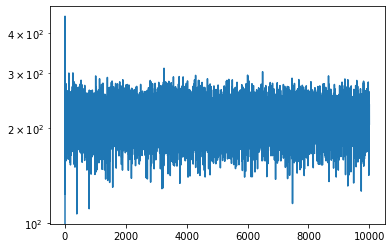

In [ ]:
plt.semilogy(loss)

In [ ]:
g = m.return_guide()
out = g.quantiles([0.025, 0.5, 0.975])
print(out)

{'theta': [tensor([[-0.9083],
        [ 0.0313],
        [ 0.9278],
        [-0.1077],
        [-0.3378]], grad_fn=<ViewBackward>), tensor([[ 0.0119],
        [ 0.7002],
        [ 1.7007],
        [ 0.1868],
        [-0.0069]], grad_fn=<ViewBackward>), tensor([[0.9320],
        [1.3692],
        [2.4737],
        [0.4813],
        [0.3240]], grad_fn=<ViewBackward>)]}


In [ ]:
CI = pcox.metrics(surv=surv.numpy(), linpred=(torch.mm(X, out['theta'][1]).detach().numpy()))
print(CI.concordance())

0.6779510811768876


Overall the estimates are similar to the result that the authors have reported for the Poisson model and a standard frequentist Cox regression. 

The major difference occurs for the first parameter (stage==2) which in our case is 0.01, while the other two approaches report it as close to 0.15. 
However, the uncertainty around the estimates is quite large with hardly any evidence for a non-zero effect, hence an estimate of 0 seems reasonable as well. 

A similar case, at lower extend, happens for the last parameter diagyr which we report as -0.0069 and the other two studies around -0.04, again with large uncertainty. 

Overall we can obtain similar results while subsampling the data. 
In comparison with the frequentist Cox model, our parameter estimates have a slightly higher concordance with 0.678 compared to 0.674.



In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R 
install.packages('survival')
install.packages('glmnet')

In [ ]:
%%R
set.seed(8)
library("survival")
data("larynx")
 
# Covariates
larynx$age <- as.numeric(scale(larynx$age))
larynx$diagyr <- as.numeric(scale(larynx$diagyr))
larynx$stage <- as.factor(larynx$stage)
 
summary(coxph(Surv(time, delta)~., data=larynx))